# Model Training

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from pylab import rcParams
import plotly.graph_objects as go

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
# from statsmodels.tsa.api import ExponentialSmoothing
import statsmodels.api as sm
import pmdarima as pm

import warnings
warnings.filterwarnings('ignore')

from scripts.helper_functions import *

In [2]:
sie_df = pd.read_csv("./data/arctic_sie_clean.csv")
sie_df.head(10)

,date,extent_million_sq_km
0,1978-10-26,10.231
1,1978-10-28,10.420
2,1978-10-30,10.557
3,1978-11-01,10.670
4,1978-11-03,10.777
5,1978-11-05,10.968
6,1978-11-07,11.080
7,1978-11-09,11.189
8,1978-11-11,11.314
9,1978-11-13,11.460


The dataset contains a daily measurement over a 30-year period. Therefore, we keep the first 25 years for training and the last 5 years for testing. The test size accounts for 60 months between 2013 and 2017. Plus, an additional 3 months in 2018 -- all multiplied by 30 (average number of measurements per month).

### Data Partitioning & Preprocessing

In [3]:
# Set the split boundary
split_date = '2013-01-01'

# Partitioning the dataset
train_nfc = sie_df[sie_df['date'] < split_date]
test_nfc = sie_df[sie_df['date'] >= split_date]

In order to set yearly based limitations to partition the dataset, a split date parameter is used to separate the data at the year's start.

#### Naive Forecast

In [4]:
train_len = len(train_nfc)

# Copy test set
y_hat = test_nfc.copy()
y_hat['naive_forecast'] = train_nfc['extent_million_sq_km'][train_len-1]

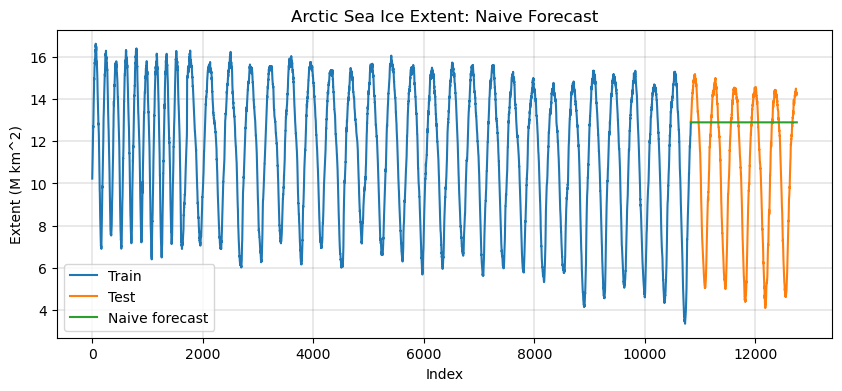

In [5]:
# Train, Test, and Forecast
plt.figure(figsize=(10, 4))
plt.grid(color='grey', linestyle='-', linewidth=0.25)

plt.plot(train_nfc['extent_million_sq_km'], label='Train')
plt.plot(test_nfc['extent_million_sq_km'], label='Test')
plt.plot(y_hat['naive_forecast'], label='Naive forecast')

plt.legend(loc='best')
plt.title('Arctic Sea Ice Extent: Naive Forecast')
plt.xlabel('Index')
plt.ylabel('Extent (M km^2)')

plt.savefig('figures/sie_naive_fc.png')
plt.show()

#### Seasonal Naive Forecast

In [6]:
# Copy cleaned SIE dataframe 
df = sie_df.copy()

# Create a seasonal naive forecast assuming a yearly seasonality
df['seasonal_naive_forecast'] = df['extent_million_sq_km'].shift(30*365)

# Store observations
y_hat['seasonal_naive_forecast'] = df['seasonal_naive_forecast'].dropna().reset_index(drop=True)

print(df['seasonal_naive_forecast'].shape[0], y_hat['seasonal_naive_forecast'].shape[0])

12751 1916


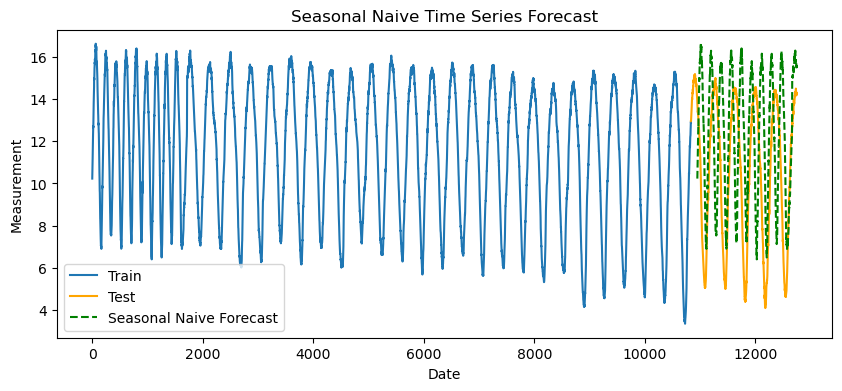

In [7]:
# Plot the actual values and the seasonal naive forecast
plt.figure(figsize=(10, 4))

plt.plot(train_nfc['extent_million_sq_km'], label='Train')
plt.plot(test_nfc['extent_million_sq_km'], label='Test', color='orange')
plt.plot(df['seasonal_naive_forecast'], label='Seasonal Naive Forecast', color='green', linestyle='dashed')

# X-ticks of every 5th year 
# xticks_yrs = pd.to_datetime(df['date']).dt.year.unique()[::5]
# plt.xticks(xticks_yrs, ha='right', rotation=45)

plt.title('Seasonal Naive Time Series Forecast')
plt.xlabel('Date')
plt.ylabel('Measurement')
plt.legend()
plt.show()

In [8]:
# # Perform Seasonal Naive Forecast on the validation set
# y_hat['seasonal_naive_forecast'] = test_nfc['date'].apply(
#     lambda x: train_nfc.loc[
#         (train_nfc['date'].dt.month == x.month) & (train_nfc['date'].dt.day == x.day),
#         'measurement'
#     ].iloc[-1] if x.month in train_nfc['date'].dt.month.values and x.day in train_nfc['date'].dt.day.values
#     else None
# )

In [9]:
# # Assuming df['date'] is in datetime format and df['measurement'] is the target variable
# df['date'] = pd.to_datetime(df['date'])

# # Create a validation set (e.g., using the last N data points)
# validation_set_size = 12  # Adjust the size based on your dataset
# train_df = df[:-validation_set_size]
# validation_df = df[-validation_set_size:]

# # Perform Seasonal Naive Forecast on the validation set
# y_hat['seasonal_naive_forecast'] = test_nfc['date'].apply(
#     lambda x: train_nfc.loc[train_nfc['date'].dt.month == x.month, 'measurement'].iloc[-1]
#     if x.month in train_nfc['date'].dt.month.values
#     else None
# )

# # Plot the actual values and the seasonal naive forecast
# plt.figure(figsize=(10, 4))

# sns.lineplot(x='date', y='measurement', data=train_nfc, label='Training Data')
# sns.lineplot(x='date', y='measurement', data=test_nfc, label='Actual Values (Validation)', linestyle='dashed')
# sns.lineplot(x='date', y='seasonal_naive_forecast', data=y_hat, label='Seasonal Naive Forecast', linestyle='dashed')

# plt.title('Seasonal Naive Forecast with Validation Set')
# plt.xlabel('Date')
# plt.ylabel('Measurement')
# plt.legend()
# plt.show()

#### Simple Average Forecast

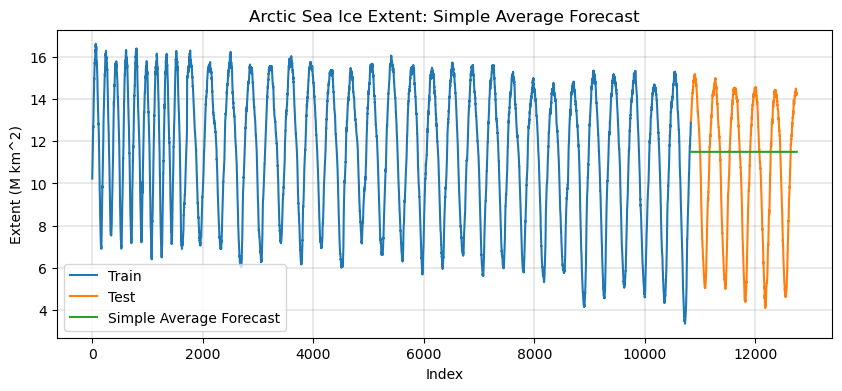

In [10]:
plt.figure(figsize=(10, 4))
plt.grid(color='grey', linestyle='-', linewidth=0.25)

# Average previously observed points
y_hat['avg_forecast'] = train_nfc['extent_million_sq_km'].mean()

plt.plot(train_nfc['extent_million_sq_km'], label='Train')
plt.plot(test_nfc['extent_million_sq_km'], label='Test')
plt.plot(y_hat['avg_forecast'], label='Simple Average Forecast')

plt.legend(loc='best')
plt.title('Arctic Sea Ice Extent: Simple Average Forecast')
plt.xlabel('Index')
plt.ylabel('Extent (M km^2)')

plt.savefig('figures/sie_simpleavg_fc.png')
plt.show()

### Moving Average Forecast

- moving average smoothing
- with large datasets, want to see it on a global scale

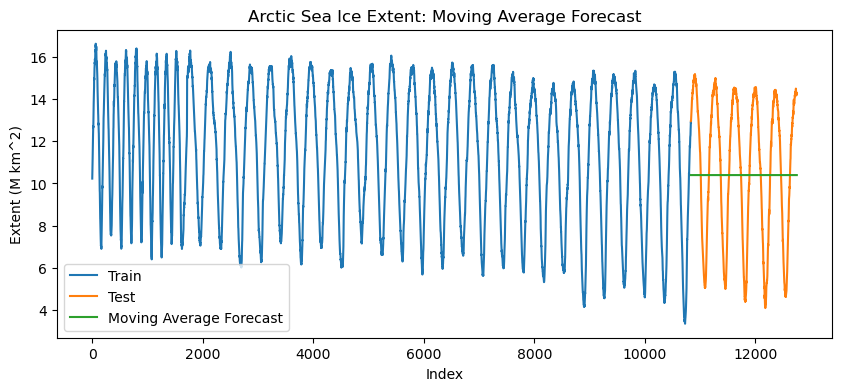

In [11]:
plt.figure(figsize=(10,4))

# Create moving average forecast for each cycle (365 days)
y_hat['moving_avg_forecast'] = train_nfc['extent_million_sq_km'].rolling(365).mean().iloc[-1]

# Plot train, test, and forecast values
plt.plot(train_nfc['extent_million_sq_km'], label='Train')
plt.plot(test_nfc['extent_million_sq_km'], label='Test')
plt.plot(y_hat['moving_avg_forecast'], label='Moving Average Forecast')

plt.title('Arctic Sea Ice Extent: Moving Average Forecast')
plt.xlabel('Index')
plt.ylabel('Extent (M km^2)')
plt.legend(loc='best')
plt.show()

### Holt's Linear Trend

In [12]:
# sm.tsa.seasonal_decompose(train.Count).plot()
# result = sm.tsa.stattools.adfuller(train.Count)
# plt.show()

In [13]:
# y_hat_avg = test.copy()

# fit1 = Holt(np.asarray(train['Count'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
# y_hat_avg['Holt_linear'] = fit1.forecast(len(test))

# plt.figure(figsize=(16,8))
# plt.plot(train['Count'], label='Train')
# plt.plot(test['Count'], label='Test')
# plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
# plt.legend(loc='best')
# plt.show()

### Holt-Winters

- handles time series well

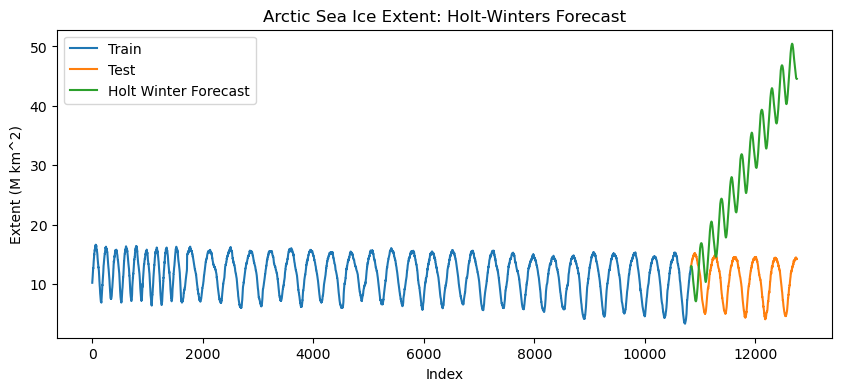

In [14]:
plt.figure(figsize=(10,4))

# Fit Holt-Winters Algorithm
fit_hw = smt.ExponentialSmoothing(np.asarray(train_nfc['extent_million_sq_km']), 
                                  seasonal_periods=365, trend='add', seasonal='add',).fit()
y_hat['holt_winter_forecast'] = fit_hw.forecast(len(test_nfc))

plt.plot(train_nfc['extent_million_sq_km'], label='Train')
plt.plot(test_nfc['extent_million_sq_km'], label='Test')
plt.plot(y_hat['holt_winter_forecast'], label='Holt Winter Forecast')

plt.title('Arctic Sea Ice Extent: Holt-Winters Forecast')
plt.xlabel('Index')
plt.ylabel('Extent (M km^2)')
plt.legend(loc='best')
plt.show()

In [15]:
# Make predictions with Holt-Winters
preds_hw = fit_hw.predict(len(train_nfc), len(train_nfc)+len(test_nfc)-1)
print(len(preds_hw))


1916


In [16]:
y_hat['hw_predictions'] = preds_hw

### SARIMA

In [26]:
train_sarima = train_nfc.copy()
train_sarima['date'] = pd.to_datetime(train_sarima['date'], infer_datetime_format=True)
train_sarima.index = train_sarima['date']
train_sarima = train_sarima.drop(columns=['date'])

test_sarima = test_nfc.copy()
test_sarima['date'] = pd.to_datetime(test_sarima['date'], infer_datetime_format=True)
test_sarima.index = test_sarima['date']
test_sarima = test_sarima.drop(columns=['date'])

# y_hat.index = y_hat['date']
# y_hat = y_hat.drop(columns=['date'])

In [27]:
# y_hat.reset_index()

In [ ]:
plt.figure(figsize=(10,4))

fit_sarima = smt.statespace.SARIMAX(train_sarima['extent_million_sq_km'], 
                                       order=(2, 1, 4), seasonal_order=(0,1,1,7)).fit()
y_hat['SARIMA'] = fit_sarima.predict(start='2013-01-01', end='2018-03-31', dynamic=True)

plt.plot(train_sarima['extent_million_sq_km'], label='Train')
plt.plot(test_sarima['extent_million_sq_km'], label='Test')
# plt.plot(y_hat['SARIMA'], label='SARIMA')

plt.title('Arctic Sea Ice Extent: SARIMA Forecast')
plt.xlabel('Index')
plt.ylabel('Extent (M km^2)')
plt.legend(loc='best')
plt.show()

In [22]:
# Fit your model
model = pm.auto_arima(train_sarima['extent_million_sq_km'], seasonal=True, m=12)

# make your forecasts
# forecasts = model.predict(test_sarima['extent_million_sq_km'].shape[0])  # predict N steps into the future
forecast = model.predict(test_nfc['extent_million_sq_km'].shape[0])

In [38]:
forecast

10835    12.949312
10836    12.996282
10837    13.042524
10838    13.088172
10839    13.137606
           ...    
12746    16.425249
12747    16.425249
12748    16.425249
12749    16.425249
12750    16.425249
Length: 1916, dtype: float64

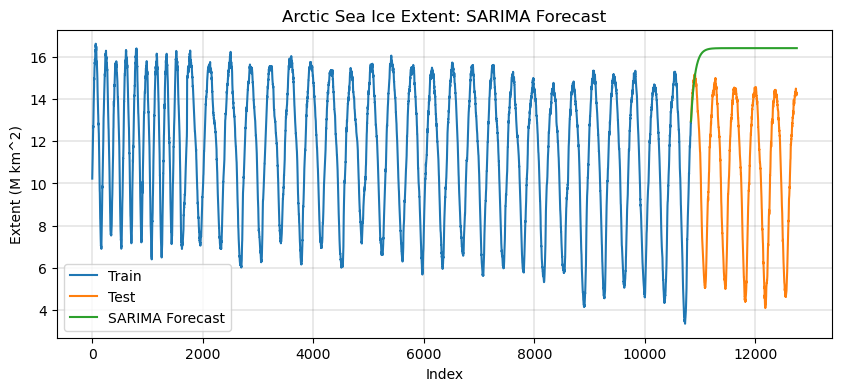

In [29]:
# Visualize SARIMA forecasts
plt.figure(figsize=(10,4))
plt.grid(color='grey', linestyle='-', linewidth=0.25)

plt.plot(train_nfc['extent_million_sq_km'], label='Train')
plt.plot(test_nfc['extent_million_sq_km'], label='Test')
plt.plot(forecast, label='SARIMA Forecast')

plt.title('Arctic Sea Ice Extent: SARIMA Forecast')
plt.xlabel('Index')
plt.ylabel('Extent (M km^2)')
plt.legend(loc='best')
plt.show()

### Evaluation Metrics

In [35]:
# Outcome Variable parameter
outcome_var = y_hat['extent_million_sq_km']

# Calculate Evaluation Metrics
rmse_fc, mape_fc = eval_metrics(outcome_var, y_hat['naive_forecast'])
rmse_sa, mape_sa = eval_metrics(outcome_var, y_hat['avg_forecast'])
rmse_ma, mape_ma = eval_metrics(outcome_var, y_hat['moving_avg_forecast'])
rmse_hw, mape_hw = eval_metrics(outcome_var, y_hat['holt_winter_forecast'])
# rmse_sarima, mape_sarima = eval_metrics(outcome_var, y_hat['SARIMA'])

In [36]:
# Calculate RMSE and MAPE for SARIMA Forecast
rmse_sarima = np.sqrt(mean_squared_error(outcome_var, forecast)).round(2)

mape_sarima = np.round(np.mean(np.abs(outcome_var - forecast) / outcome_var) * 100, 2)

In [37]:
# Print Evaluation Results
results = pd.DataFrame({'Method':['Naive Forecast', 
                                  'Simple Average', 
                                  'Moving Average',
                                  'Holt-Winters',
                                  'SARIMA'
                                  ], 
                        'MAPE': [mape_fc, mape_sa, mape_ma, mape_hw, mape_sarima], 
                        'RMSE': [rmse_fc, rmse_sa, rmse_ma, rmse_hw, rmse_sarima],
                        'Forecast': [y_hat['naive_forecast'].iloc[0], 
                                     y_hat['avg_forecast'].iloc[0],
                                     y_hat['moving_avg_forecast'].iloc[0],
                                     None,
                                     None]})
results

,Method,MAPE,RMSE,Forecast
0,Naive Forecast,44.08,4.03,12.902000
1,Simple Average,38.30,3.47,11.501372
2,Moving Average,35.72,3.39,10.398025
3,Holt-Winters,214.59,21.93,NaN
4,SARIMA,NaN,6.60,NaN
